In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math


In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [4]:
def find_end_stf(momentrate, time):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [5]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [6]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [7]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

In [8]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [9]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = [[]]
all_relative_root_times_for_event = {}

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for i, row in combined.iterrows():

        scardec_name = row['scardec']

        if scardec_name == '0' or scardec_name == 0:
            continue
        #print(scardec_name)
        momentrate, time = get_scardec_stf(scardec_name, wanted_type='fctmoy')

        detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time

        not_zero = np.where(momentrate > 0)[0]

        dx = time[1]-time[0]

        start = 0 # min(not_zero)
        end = detected_end - detected_start # max(not_zero)
        points_before_zero = 0 # abs(min(time)/dx)

        duration = detected_end_time
        durations.append(duration)

        start_time = 0
        end_time = detected_end_time

        total_moment = scipy.integrate.simpson(momentrate[0:end], dx = dx)
        moments.append(total_moment)
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time,
                                                momentrate,
                                                start,
                                                points_before_zero,
                                                proportion,))
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        save_key = row.event

        if save_key in all_relative_root_times_for_event.keys():
            to_save = all_relative_root_times_for_event[save_key]
            to_save.append((root_time-start_time)/duration)
            all_relative_root_times_for_event[save_key] = to_save
        else:
            all_relative_root_times_for_event[save_key] = [(root_time-start_time)/duration]

        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(scardec_name)

    root_times = np.array(root_times)
    print(root_times)
    durations = np.array(durations)
    moments = np.log10(np.array(moments))
    relative_root_times = np.array(relative_root_times)

    rel_root_times = relative_root_times/durations
    all_root_times.append(root_times[0])
    all_relative_root_times.append(rel_root_times)


0.1
[8.859375   4.78125    2.0390625  ... 1.90173339 2.109375   2.25      ]
0.2
[10.6171875   6.046875    2.3203125  ...  2.25390624  2.6015625
  2.53125   ]
0.3
[12.375       7.1015625   2.6015625  ...  2.60607909  3.1640625
  2.671875  ]
0.4
[15.9609375   7.9453125   2.8828125  ...  2.74694823  3.7265625
  2.8125    ]
0.5
[17.2265625   8.71875     3.1640625  ...  3.02868651  5.5546875
  2.953125  ]
0.6
[17.859375    9.28125     3.4453125  ...  3.38085936  6.5390625
  3.234375  ]
0.7
[18.6328125   9.9140625   3.796875   ...  3.66259764  7.1015625
  3.375     ]
0.8
[19.265625   10.4765625   4.078125   ...  4.01477049  7.6640625
  3.515625  ]
0.9
[20.0390625  11.25        4.359375   ...  4.43737791  8.0859375
  3.65625   ]


In [10]:
df = pd.DataFrame.from_dict(all_relative_root_times_for_event, orient='index', columns=['10', '20', '30', '40', '50', '60', '70', '80', '90'])

In [12]:
df.to_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec_relative_root_times.csv')

In [11]:
def gaussian(x, mu = 0, sigma = 1):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [12]:
def triangle(x):
    x = np.array(x)
    y = np.zeros(len(x))
    m = 1/(abs(x[0]-x[int(len(x)/2)]))
    print(m)
    y[:int(len(x)/2)] = m*x[:int(len(x)/2)]
    y[int(len(x)/2):] = -m*x[int(len(x)/2):]
    y[:int(len(x)/2)] = y[:int(len(x)/2)] - min(y[:int(len(x)/2)])
    y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [13]:
def boxcar(x):
    y = np.zeros(len(x))
    y = y + 1
    return y

In [14]:
def trapezium(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.linspace(0, 1, start_index)
    y[start_index:length-end_index] = 1
    y[length-end_index:] = 1 - np.linspace(0, 1, end_index)
    return y


In [15]:
def sine_boxcar(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.sin(np.linspace(-math.pi/2, math.pi/2, start_index))
    y[start_index:length-end_index] = 1
    y[length-end_index:] = (np.sin(np.linspace(-math.pi/2, math.pi/2, start_index)))[::-1]
    return y

In [16]:
def comparison_calculation(funct):
    proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    #print(proportion)
    durations = []
    g_root_times = []
    g_relative_root_times = []


    for proportion in proportions_list:

        diff = []
        moments = []


        # Generate x values
        x = np.linspace(-4, 4, 100)

        # Generate y values
        y = funct(x)

        # Use the generated Gaussian values
        momentrate_opt, time_opt = y, x

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        g_root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        g_root_idx = np.floor(g_root/dx)
        g_root_time = g_root_idx*dx
        g_root_times.append(g_root_time)
        g_relative_root_times.append(g_root_time-start_time)

    g_relative_root_times = np.array(g_relative_root_times)
    return g_relative_root_times/durations

In [17]:
all_relative_root_times.append([])

0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33


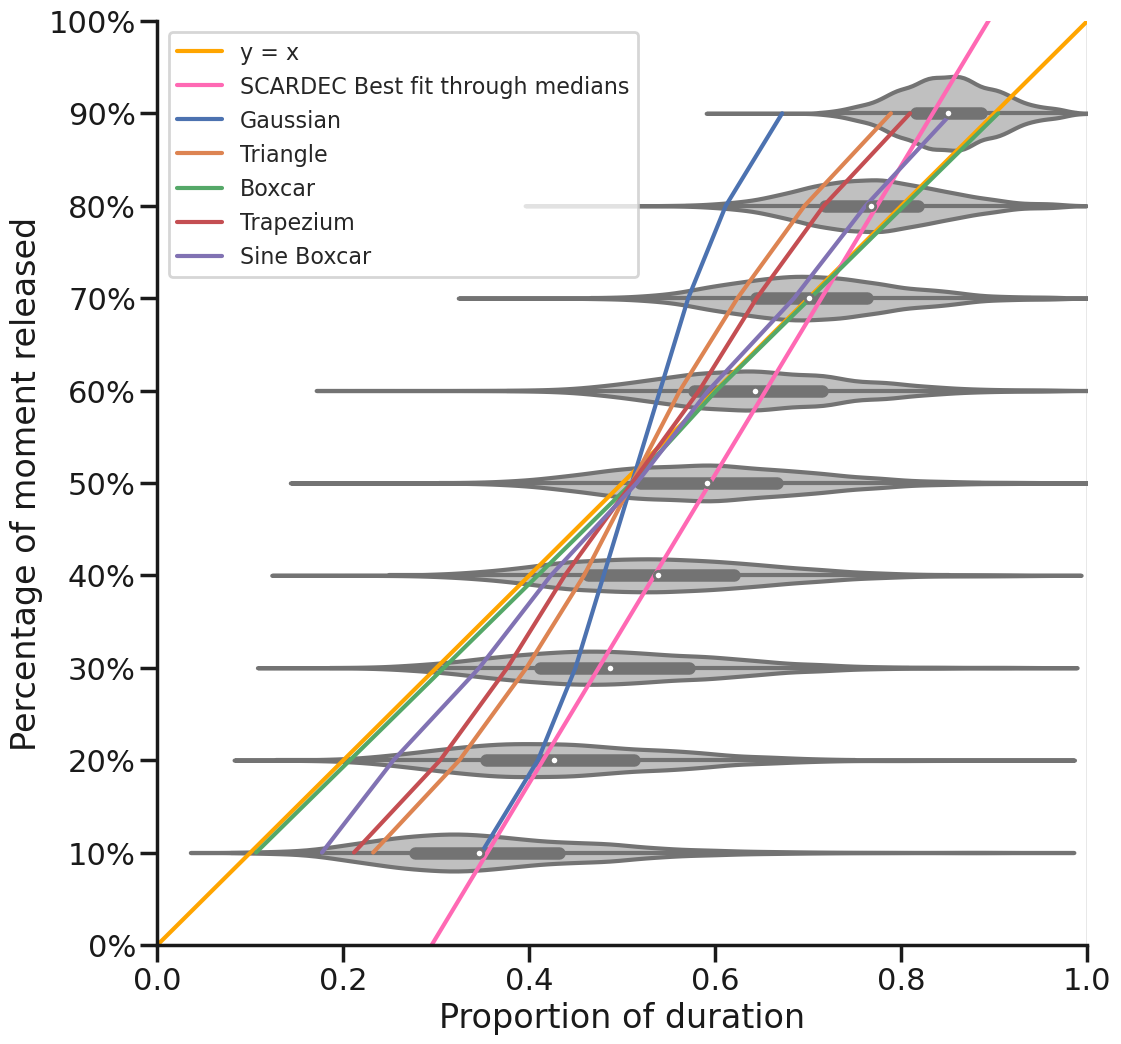

In [18]:
sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(10,10), "font.size":20})

sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':20})

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)
plt.rc('legend',fontsize=16)


ax = sns.violinplot(data = all_relative_root_times,
               orient = 'h',
               color = 'silver')
ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

ax.set_ylabel('Percentage of moment released')
ax.set_xlabel('Proportion of duration')

ax.invert_yaxis()

ax.plot(np.arange(0, 1.1, 0.1),
        np.arange(0, 11, 1),
        c = 'orange',
        label = 'y = x',)

# Calculate the line of best fit
m, b = np.polyfit(np.mean(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
#         c='red',
#         label = 'Mean LoBF',
#         linestyle = '--')

# Calculate the line of best fit
m, b = np.polyfit(np.median(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
ax.plot(np.arange(0, 1, 0.1),
        m * np.arange(0, 1, 0.1) + b,
        c='hotpink',
        label = 'SCARDEC Best fit through medians',
        linestyle = '-')


for funct, label in zip([gaussian, triangle, boxcar, trapezium, sine_boxcar], ['Gaussian', 'Triangle', 'Boxcar', 'Trapezium', 'Sine Boxcar']):
        ax.plot(comparison_calculation(funct), np.arange(1, 10, 1), label = label)

plt.ylim(-0, 10)
plt.xlim(0, 1)

ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
plt.legend()
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/comparisons_to_predictions/violinplot_fraction_of_duration_for_percent_moment_scardec_only_corrected_ends.png', dpi = 300)

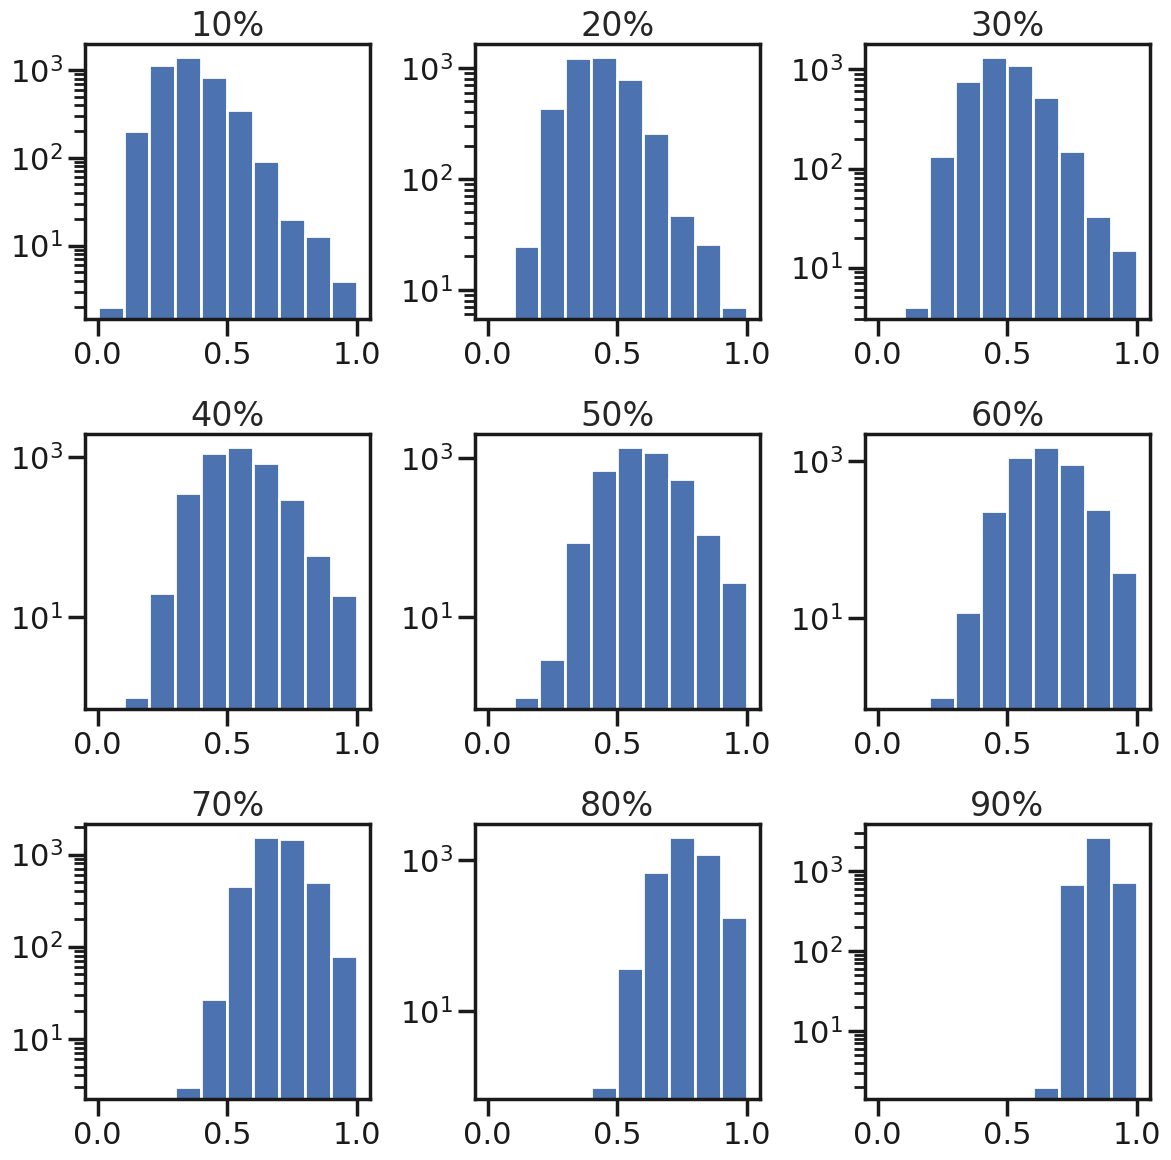

In [19]:
fig, axs = plt.subplots(3,3)
for i in range(9):
    ax = axs[i//3, i%3]
    ax.hist(all_relative_root_times[i+1], bins = np.arange(0 , 1.1, 0.1))
    ax.set_title(f'{proportions_list[i]*100:.0f}%')

    ax.set_yscale('log')

plt.tight_layout()
# plt.hist(all_relative_root_times[1:2])
# plt.yscale('log')

20070427_1349
20111006_1112
20060729_1953
19990508_1944
20050726_1411
20211126_0413
20030309_1036
20011202_0247
20001205_2211
20190729_2037
20110912_2244
20100104_1128
20060328_1332
19940822_1726
20121205_1708
19991121_0351
19951201_0520
20200919_2109
20221208_0050
20050325_0104
20181030_0213
20070820_2242
20140729_1046
20190405_0956
20071110_2319
20221116_2226
20200516_0315
20220519_0923
20211115_0423
20070525_1747
20130222_1201
19971017_1502
20060307_0628
20140827_2311
20000625_0634
19950802_0014
20131011_2125
20110608_0306
20080517_1708
19920713_1811
20041027_2034
20130801_2001
20100722_0503
19940629_1822
19990203_0635
19990406_0822
20061026_1428
20111213_0752
19990828_1240
19930722_0457
20220103_0209
19950629_2302
19981124_2354
19991213_0930
20170619_0915
20070123_1716
20110716_1706
20170907_1726
20041121_1107
19940223_0802
20051025_1940
20220630_1840
20060815_0305
20210326_2202
19960228_0944
20071118_0540
19980425_0607
20060922_0232
20100304_2239
19981011_1204
20131223_0912
201506

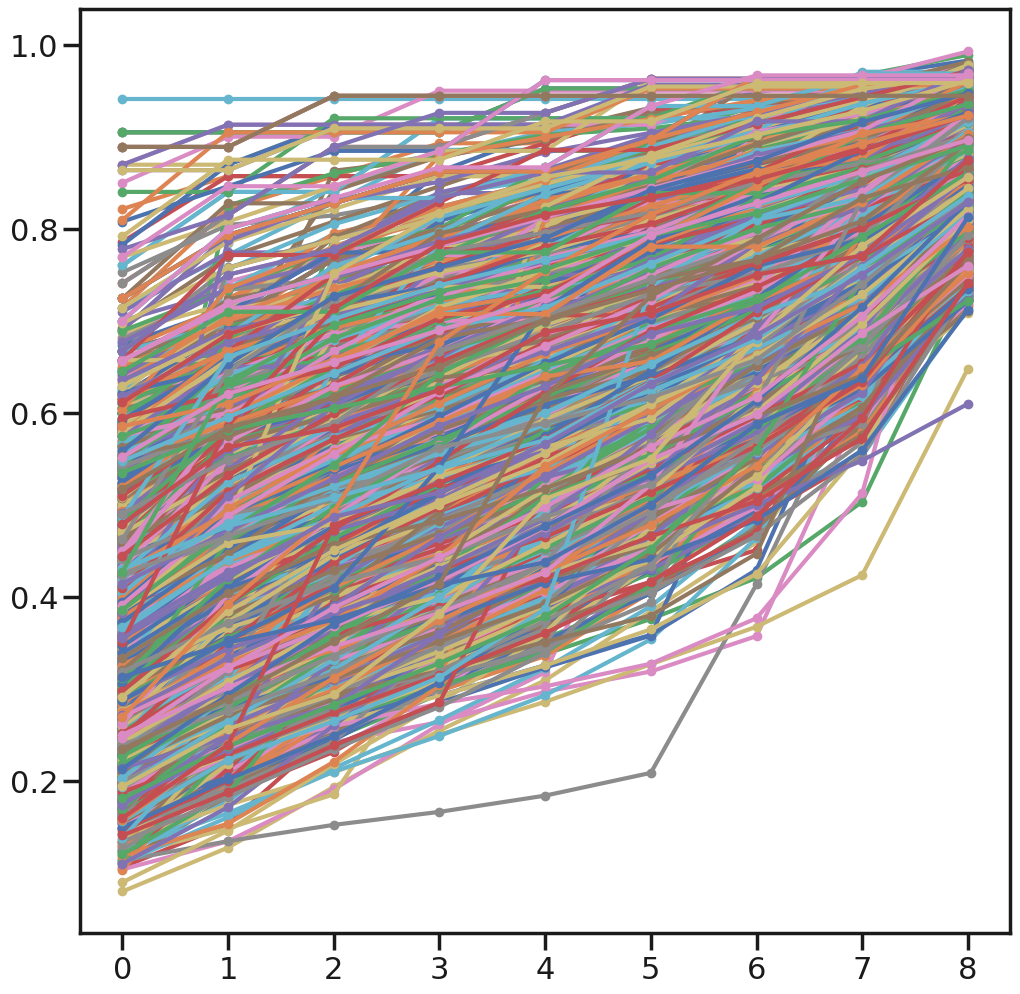

In [20]:
count = 0
for key in all_relative_root_times_for_event.keys():
    plt.plot(np.array(all_relative_root_times_for_event[key]), marker = '.')
    if all_relative_root_times_for_event[key][0] > 0.5:
        print(key)
    if all_relative_root_times_for_event[key][3] < 0.1:
        print(key)
    # count += 1
    # if count > 100:
    #     break
plt.show()